PPP (with DnCNN) Image Deconvolution (ADMM Solver)
==================================================

This example demonstrates the solution of an image deconvolution problem
using the ADMM Plug-and-Play Priors (PPP) algorithm
<cite data-cite="venkatakrishnan-2013-plugandplay2"/> with the DnCNN
<cite data-cite="zhang-2017-dncnn"/> denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Set up forward operator and test signal consisting of blurred signal with
additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = random.randn(Ax.shape)
y = Ax + σ * noise

Set up the problem to be solved. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + R(\mathbf{x}) \;$$

where $R(\cdot)$ is a pseudo-functional having the DnCNN denoiser as its
proximal operator. The problem is solved via ADMM, using the standard
variable splitting for problems of this form, which requires the use of
conjugate gradient sub-iterations in the ADMM step that involves the data
fidelity term.

In [4]:
f = loss.SquaredL2Loss(y=y, A=A)
g = functional.DnCNN("17M")
C = linop.Identity(x_gt.shape)

Set up ADMM solver.

In [5]:
ρ = 0.2  # ADMM penalty parameter
maxiter = 10  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.T @ y,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 30}),
    itstat_options={"display": True},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  2.82e+00  2.471e+01  3.087e+01      5  7.435e-04


   1  3.11e+00  8.216e+00  1.630e+01      5  5.307e-04


   2  3.31e+00  5.068e+00  1.023e+01      4  5.072e-04


   3  3.51e+00  3.601e+00  6.929e+00      3  6.830e-04
   4  3.71e+00  2.657e+00  4.912e+00      3  3.985e-04


   5  3.91e+00  1.830e+00  3.516e+00      2  6.866e-04
   6  4.11e+00  1.339e+00  2.726e+00      2  5.163e-04


   7  4.31e+00  9.974e-01  2.161e+00      2  3.550e-04
   8  4.51e+00  7.911e-01  1.766e+00      2  2.713e-04


   9  4.71e+00  4.772e-01  1.160e+00      1  8.405e-04


Show the recovered image.

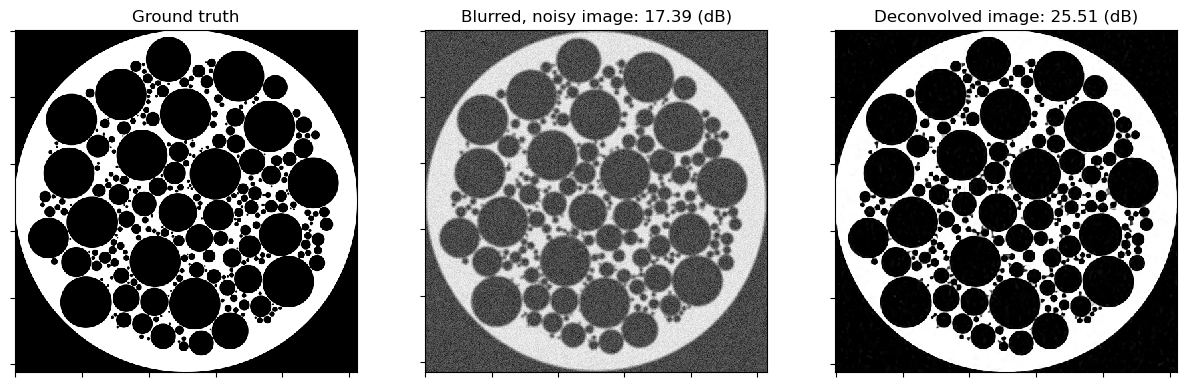

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = snp.clip(y[nc:-nc, nc:-nc], 0, 1)
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

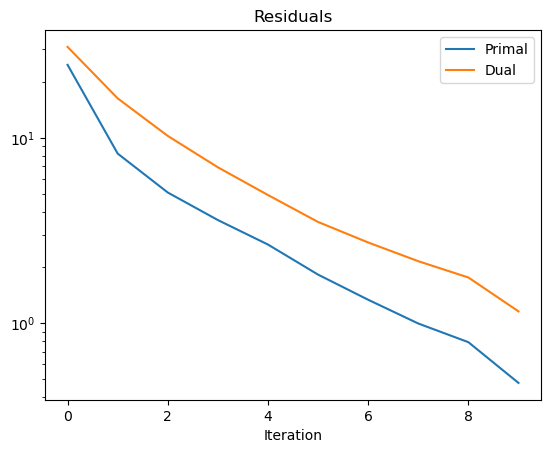

In [8]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)